### EEG Preprocessing with MNE

In [4]:
%matplotlib inline
import os
import os.path as op
import mne
import numpy as np
import pandas as pd

### 1. Importing Raw  Data

In [5]:
examples_dir = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\raw\\sub-010002\\RSEEG\\'   # Path to the raw EEG Data folder
vhdr_file = op.join(examples_dir, 'sub-010002.vhdr')                # Path to the raw EEG header file
#vhdr_file = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\EEG_MPILMBB_LEMON\\EEG_Raw_BIDS_ID\\sub-010002\\RSEEG\\sub-010002.vhdr'
raw = mne.io.read_raw_brainvision(vhdr_file, misc='auto')        # Returns a Raw object containing BrainVision data
raw.load_data()                                                   # Loading continuous data

Extracting parameters from D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\raw\sub-010002\RSEEG\sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...


<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GiB, data loaded>

In [6]:
# Set the VEOG channel as EOG type (not EEG)
raw.set_channel_types({'VEOG': 'eog'})

# Create standard montage (10-20 system)
montage = mne.channels.make_standard_montage('standard_1005')

# Apply montage to EEG channels only
# Since VEOG is not part of the standard montage, allow missing channel info
raw.set_montage(montage, on_missing='raise')

<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GiB, data loaded>

### 2. Rereference

In [4]:
raw.set_eeg_reference('average', projection=True).apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GiB, data loaded>

### 3. Divided into EO conditions and EC conditions

In [7]:
# 1. Extract events and event_id dictionary from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)
#print(event_id)

Used Annotations descriptions: [np.str_('Comment/no USB Connection to actiCAP'), np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S200'), np.str_('Stimulus/S210')]


In [8]:
fs = int(raw.info['sfreq'])

eo_blocks = []
ec_blocks = []

# Get numeric event codes
eo_code = event_id.get('Stimulus/S200', -1)  # Eyes Open
ec_code = event_id.get('Stimulus/S210', -1)  # Eyes Closed

for i, event in enumerate(events[:-1]):  # skip last (no next)
    this_sample = event[0]
    this_code = event[2]
    
    next_sample = events[i + 1][0]
    next_code = events[i + 1][2]

    t_start = this_sample / fs
    t_end = next_sample / fs

    # Only include block if the same condition continues (no switch)
    if this_code == eo_code and next_code == eo_code:
        eo_blocks.append(raw.copy().crop(tmin=t_start, tmax=t_end, include_tmax=False))
    elif this_code == ec_code and next_code == ec_code:
        ec_blocks.append(raw.copy().crop(tmin=t_start, tmax=t_end, include_tmax=False))
    # Transitions (e.g., EO → EC or EC → EO) are skipped

# Concatenate all blocks
raw_eo = mne.concatenate_raws(eo_blocks) if eo_blocks else None
raw_ec = mne.concatenate_raws(ec_blocks) if ec_blocks else None

### 4. Filtering the data

In [9]:
# Define IIR filter parameters: 8th-order Butterworth filter
iir_params = dict(order=8, ftype='butter')

# Apply a band-pass filter from 1 to 45 Hz using zero-phase filtering
raw_eo = raw_eo.copy().filter(
    l_freq=1.,              # Lower cutoff frequency (Hz)
    h_freq=45.,             # Upper cutoff frequency (Hz)
    method='iir',           # Use IIR filtering
    iir_params=iir_params,  # Specify filter order and type
    phase='zero',           # Apply zero-phase (forward-backward) filtering to avoid phase distortion
    verbose=True            # Print filtering information
)

raw_ec = raw_ec.copy().filter(
    l_freq=1.,              # Lower cutoff frequency (Hz)
    h_freq=45.,             # Upper cutoff frequency (Hz)
    method='iir',           # Use IIR filtering
    iir_params=iir_params,  # Specify filter order and type
    phase='zero',           # Apply zero-phase (forward-backward) filtering to avoid phase distortion
    verbose=True            # Print filtering information
)

Filtering raw data in 232 contiguous segments
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB

Filtering raw data in 232 contiguous segments
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB



In [18]:
# Show a short segment of the original raw EEG (before splitting)
raw.plot(title='Original raw EEG (before block splitting)', duration=20, start=0)

Using qt as 2D backend.


In [19]:
#eo_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EO.fif'
#ec_fname = 'D:\\FY2025\\Fukuyama\\work place\\original_preprocessed_data\\sub-010002\\sub-010002_EC.fif'

# Load raw data from FIF files
#raw_eo = mne.io.read_raw_fif(eo_fname, preload=True)
#raw_ec = mne.io.read_raw_fif(ec_fname, preload=True)

In [20]:
# Plot EC condition (eyes closed)
raw_ec.plot(title='Eyes Closed (EC)', duration=20, start=0)

In [21]:
events_ec, event_id_ec = mne.events_from_annotations(raw_ec)
print(events_ec)

Used Annotations descriptions: [np.str_('Stimulus/S210')]
[[  15962       0     210]
 [  20962       0     210]
 [  20962       0     210]
 ...
 [1170979       0     210]
 [1170979       0     210]
 [1175979       0     210]]


In [22]:
# Plot EO condition (eyes open)
raw_eo.plot(title='Eyes Open (EO)', duration=20, start=0)

In [23]:
events_eo, event_id_eo = mne.events_from_annotations(raw_eo)
print(events_eo)

Used Annotations descriptions: [np.str_('Stimulus/S200')]
[[ 171871       0     200]
 [ 176871       0     200]
 [ 176871       0     200]
 ...
 [1326888       0     200]
 [1326888       0     200]
 [1331888       0     200]]


In [10]:
duration_eo = raw_eo.times[-1]
duration_ec = raw_ec.times[-1]

print(f"Eyes Open (EO) duration: {duration_eo:.2f} sec")
print(f"Eyes Closed (EC) duration: {duration_ec:.2f} sec")

Eyes Open (EO) duration: 464.01 sec
Eyes Closed (EC) duration: 464.01 sec


### 5. Independent Component Analysis  (ICA)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 14 components
Computing Infomax ICA
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 103.7s.
Using EOG channel: VEOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 25000 samples (10.0

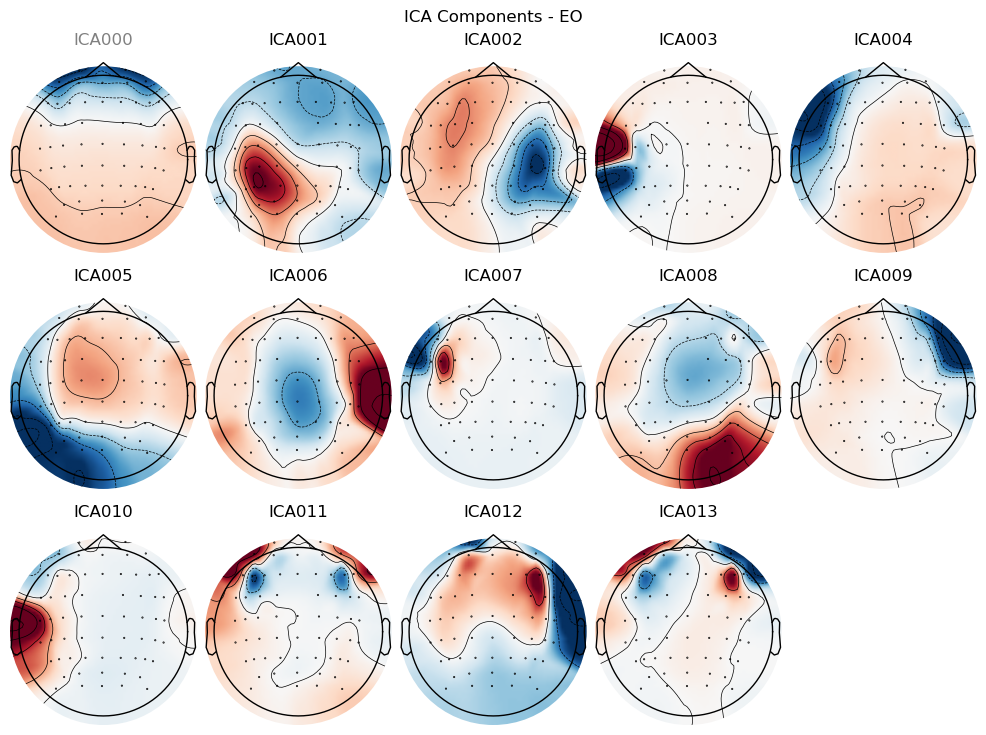

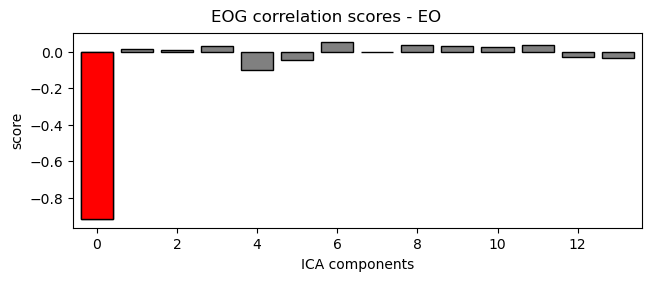

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


In [11]:
# Set parameters
n_components = 0.95  # retain 95% variance
method = 'infomax'   # ICA algorithm
random_state = 97    # for reproducibility

# ICA fitting for EO (Eyes Open) ###
ica_eo = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)
ica_eo.fit(raw_eo)

# Detect and mark EOG artifacts (blink/movement)
eog_inds_eo, eog_scores_eo = ica_eo.find_bads_eog(raw_eo)
ica_eo.exclude = eog_inds_eo  # mark bad components

# Optional: Plot the components and scores for inspection
ica_eo.plot_components(title=f'ICA Components - EO')
ica_eo.plot_scores(eog_scores_eo, title=f'EOG correlation scores - EO')

# Apply ICA to remove marked components
raw_eo_clean = ica_eo.apply(raw_eo.copy())

    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


ValueError: `dataset` input should have multiple elements.

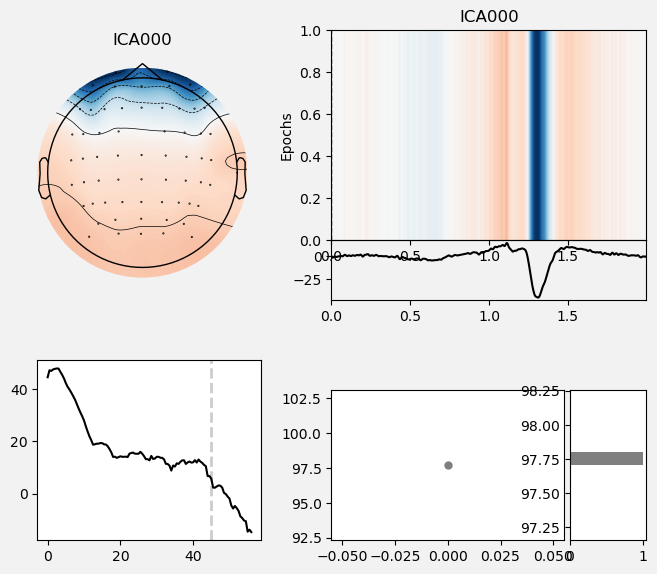

In [23]:
ica_eo.plot_properties(raw_eo, picks=[0])

Fitting ICA to data using 61 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 17 components
Computing Infomax ICA
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 120.1s.
Using EOG channel: VEOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 25000 samples (10.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


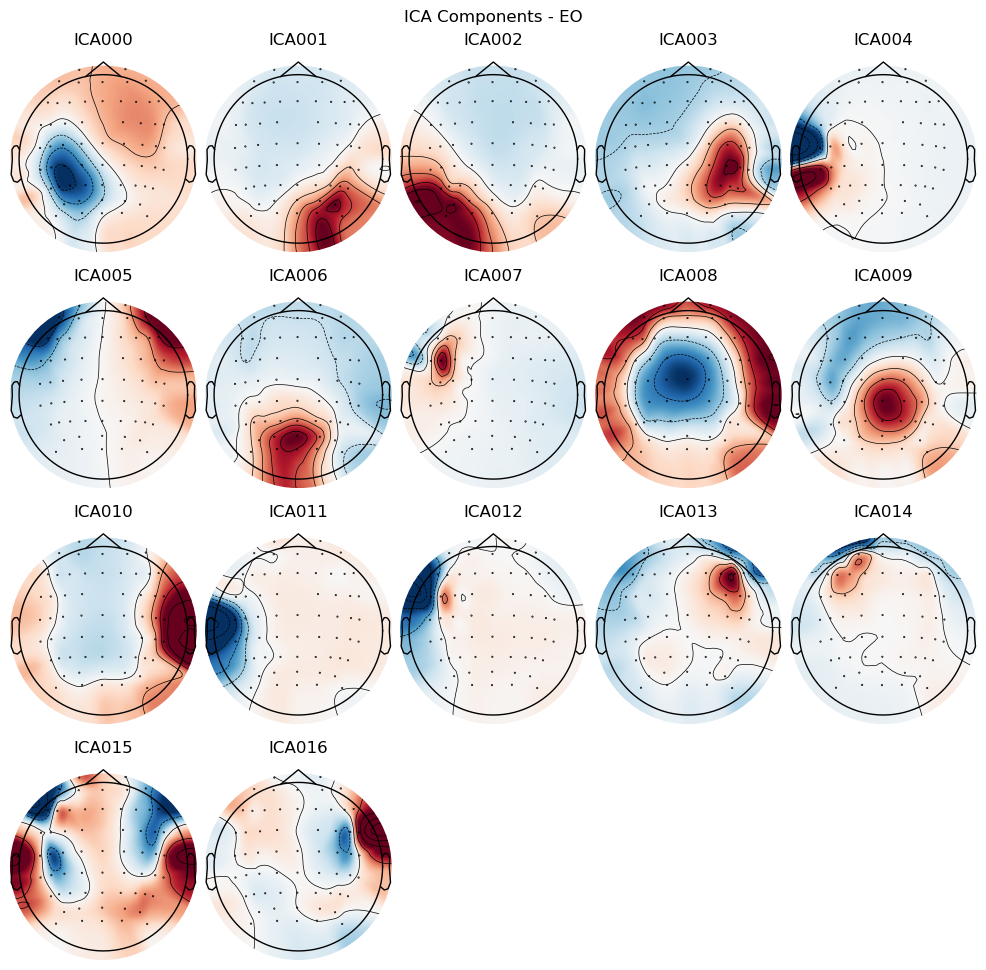

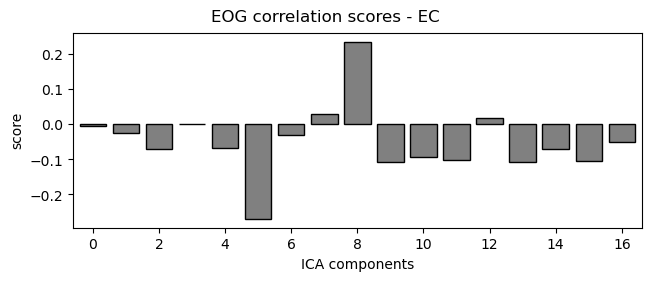

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 61 PCA components


In [12]:
### Repeat for EC (Eyes Closed) ###
ica_ec = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)
ica_ec.fit(raw_ec)

eog_inds_ec, eog_scores_ec = ica_ec.find_bads_eog(raw_ec)
ica_ec.exclude = eog_inds_ec

# Optional: Plot the components and scores for inspection
ica_ec.plot_components(title=f'ICA Components - EO')
ica_ec.plot_scores(eog_scores_ec, title=f'EOG correlation scores - EC')

raw_ec_clean = ica_ec.apply(raw_ec.copy())

In [13]:
print(raw_eo_clean)
print(raw_ec_clean)

<RawBrainVision | sub-010002.eeg, 62 x 1160017 (464.0 s), ~548.8 MiB, data loaded>
<RawBrainVision | sub-010002.eeg, 62 x 1160017 (464.0 s), ~548.8 MiB, data loaded>


In [14]:
explained_var_ratio = ica_eo.get_explained_variance_ratio(raw_eo_clean)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 0.9015294265924988


In [15]:
explained_var_ratio = ica_ec.get_explained_variance_ratio(raw_ec_clean)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 0.9517357908996276


    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


ValueError: `dataset` input should have multiple elements.

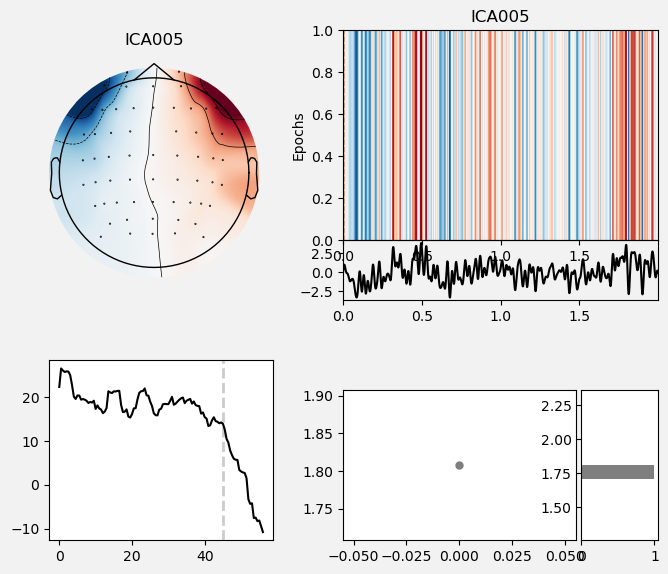

In [ ]:
ica_ec.plot_properties(raw_ec, picks=[5])
#ica_eo.plot_properties(inst=raw_eo_clean,picks=[0, 1],psd_args=dict(fmin=1., fmax=40.))

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


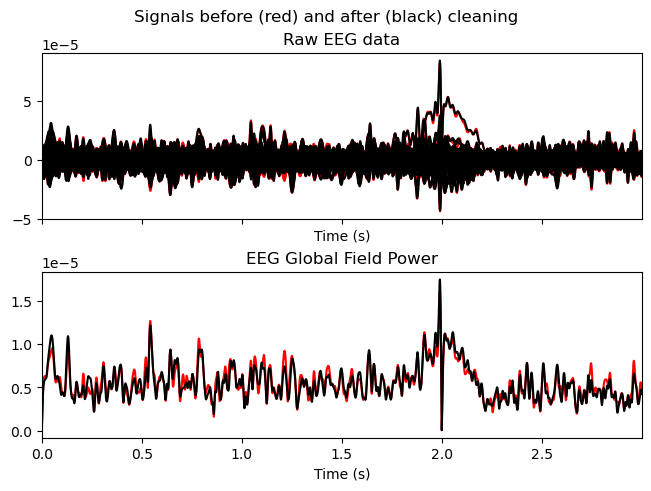

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


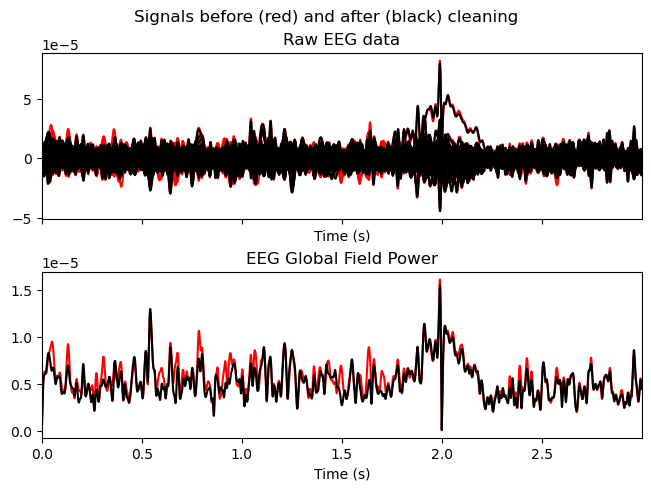

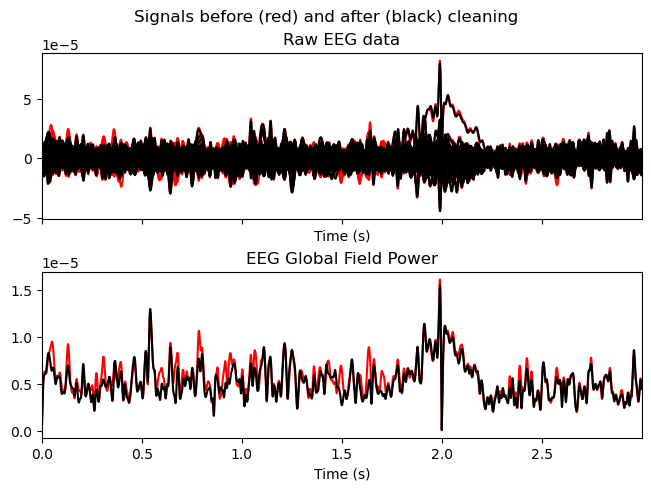

In [25]:
# blinks
ica_ec.plot_overlay(raw_ec, exclude=[0], picks="eeg")
# heartbeats
ica_ec.plot_overlay(raw_ec, exclude=[1], picks="eeg")

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


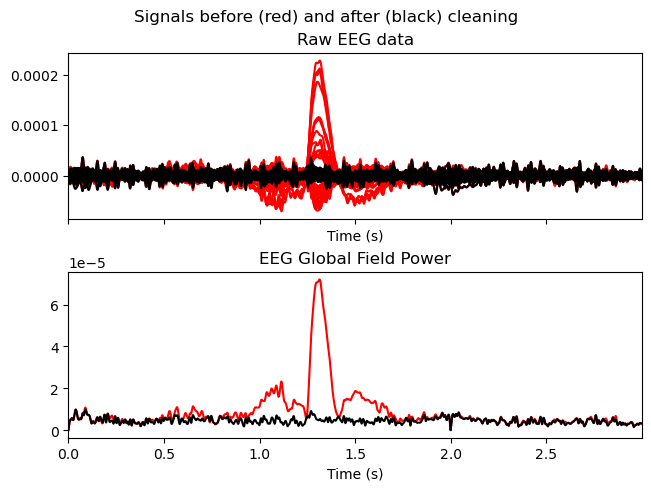

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components


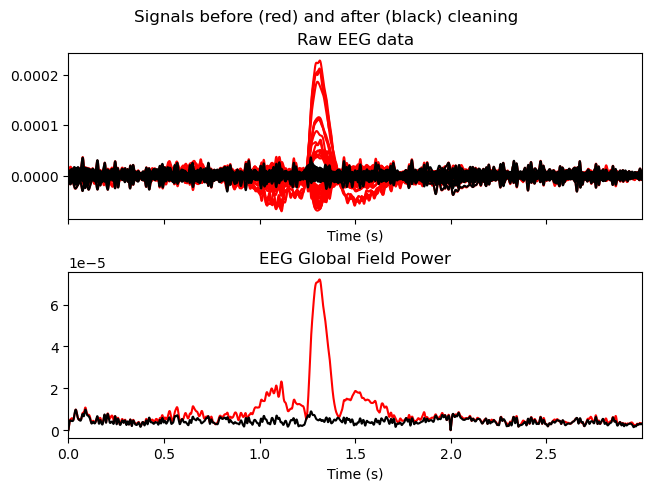

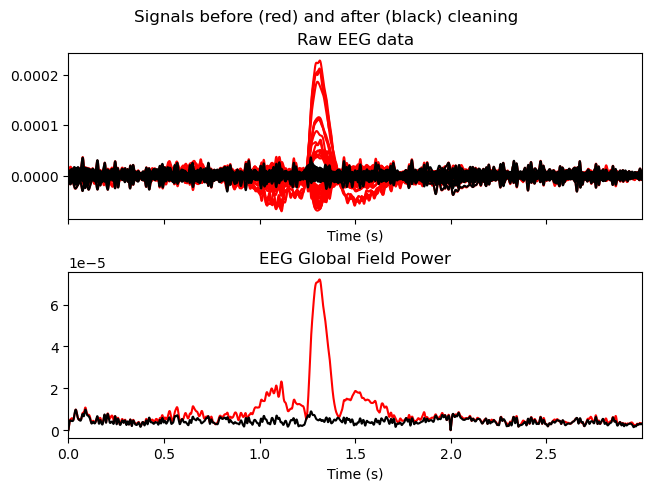

In [26]:
# blinks
ica_eo.plot_overlay(raw_eo, exclude=[0], picks="eeg")
# heartbeats
ica_eo.plot_overlay(raw_eo, exclude=[1], picks="eeg")

In [20]:
# Specify file names for saving
eo_fname = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EO.fif'
ec_fname = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EC.fif'

# Save the segmented raw data to FIF files
# overwrite=True allows overwriting if files already exist
raw_eo_clean.save(eo_fname, overwrite=True)
raw_ec_clean.save(ec_fname, overwrite=True)

Overwriting existing file.
Writing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_34936\3755438090.py:7: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_eo_clean.save(eo_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif
[done]
Overwriting existing file.
Writing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_34936\3755438090.py:8: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ec_clean.save(ec_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif
[done]


[WindowsPath('D:/FY2025/Fukuyama/work place/eeg-mri-aging-analysis/data/original_preprocessed_data/sub-010002/sub-010002_EC.fif')]

### 6. CSD

In [18]:
raw_ec_csd = mne.preprocessing.compute_current_source_density(raw_ec_clean)
raw_eo_csd = mne.preprocessing.compute_current_source_density(raw_eo_clean)

Fitted sphere radius:         95.8 mm
Origin head coordinates:      -0.8 14.2 43.8 mm
Origin device coordinates:    -0.8 14.2 43.8 mm
Fitted sphere radius:         95.8 mm
Origin head coordinates:      -0.8 14.2 43.8 mm
Origin device coordinates:    -0.8 14.2 43.8 mm


In [24]:
raw_ec_clean.plot()

Using qt as 2D backend.


In [ ]:
raw_ec_csd.plot()

Channels marked as bad:
none
Channels marked as bad:
none


### 7. Save preprocessed EEG data  

In [19]:
# Specify file names for saving
eo_fname = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EO.fif'
ec_fname = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EC.fif'

# Save the segmented raw data to FIF files
# overwrite=True allows overwriting if files already exist
raw_eo_csd.save(eo_fname, overwrite=True)
raw_ec_csd.save(ec_fname, overwrite=True)

Overwriting existing file.
Writing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_34936\1734200077.py:7: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_eo_csd.save(eo_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif
[done]
Overwriting existing file.
Writing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_34936\1734200077.py:8: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ec_csd.save(ec_fname, overwrite=True)


Closing D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif
[done]


[WindowsPath('D:/FY2025/Fukuyama/work place/eeg-mri-aging-analysis/data/original_preprocessed_data/sub-010002/sub-010002_EC.fif')]